# This script analyses the NWB files

In [55]:
# import standard libraries

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import NullFormatter
#import matplotlib.mlab as mlab
import numpy as np
import os
import scipy
from scipy import stats
import pandas as pd 
#from scipy import stats
import csv
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import manifold
from time import time
from matplotlib.colors import ListedColormap
from sklearn import clone
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from numpy import genfromtxt



# Plotting options
%matplotlib inline

# Change parameters of the Figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size    

# change the backgroud
#plt.style.use(['seaborn-notebook'])

matplotlib.rcParams.update({'font.size': 15})
#plt.style.use(['dark_background'])

# Load features and labels

In [56]:
# load the feature matrix
all_features_matrix = genfromtxt('ALL_EPHYS_FEATURES_EXP_hipp_GC.csv', delimiter=' ')

# load the cell_type names
with open('ALL_EPHYS_EXP_CELL_CELL_NAMES_hipp_GC.csv', 'rb') as csvfile:
    data = list(csv.reader(csvfile))
cell_names=data[0]

# load patient labels
with open('ALL_EPHYS_EXP_PATIENT_LABELS_hipp_GC.csv', 'rb') as csvfile:
    data = list(csv.reader(csvfile))
patient_label=data[0]
patient_label=map(float, patient_label)
patient_label=np.array(patient_label)
patient_label.astype(int)

# load the cell_type names
with open('ALL_EPHYS_EXP_FEATURE_NAMES_hipp_GC.csv', 'rb') as csvfile:
    data = list(csv.reader(csvfile))
feature_names=data[0]

# Find indexes of the model cells

In [138]:
# find cell names which are specific for 24 cells for WG1 and WG4

wg1_cells_best=['1706014110201.nwb','1706014110202.nwb','1706014110502.nwb','1706014110703.nwb','1706014110704.nwb','1706015210802.nwb','1706015210901.nwb','1706015210902.nwb','1706015210904.nwb','1706015210906.nwb','1706015210907.nwb','1706015211001.nwb']
wg4_cells_best=['1606013050102.nwb','1606013050103.nwb','1606013050301.nwb','1606013050501.nwb','1606013050504.nwb','1706012210307.nwb','1706012210308.nwb','1706012210403.nwb','1706012210501.nwb','1706012210502.nwb','1706012211201.nwb','1706012211205.nwb']

# find the indexes of the best cells

both = set(wg1_cells_best).intersection(cell_names)
wg1_best_idx = [cell_names.index(x) for x in both]
wg1_best_idx=np.array(wg1_best_idx)
print 'Indexes of wg1 model cells'
print wg1_best_idx

print

both = set(wg4_cells_best).intersection(cell_names)
wg4_best_idx = [cell_names.index(x) for x in both]
wg4_best_idx=np.array(wg4_best_idx)
print 'Indexes of wg4 model cells'
print wg4_best_idx


Indexes of wg1 model cells
[50 46 28 51 48 49 31 32 52 35 36 56]

Indexes of wg4 model cells
[ 2 13  4 16 15 18  5  6 25  7 23]


# Remove all rows that have more than 2 NaNs

Resulting matrix shape
(112, 31)


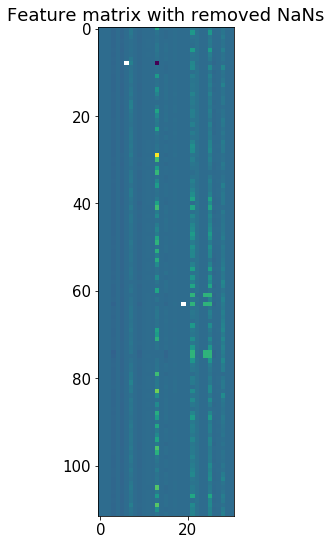

In [124]:
# remove all rows that have more than 5 NaNs

n_nan=np.zeros(len(all_features_matrix))

for i in np.arange(len(all_features_matrix)):
    # count the number of nans
    n_nan[i] = len(np.argwhere(np.isnan(all_features_matrix[i,:])))
    

# set up a threshold for the nan numbers
nan_thr=2
all_features_matrix_no_nan=all_features_matrix[np.where(n_nan<nan_thr)[0]]

plt.imshow(all_features_matrix_no_nan)
plt.title('Feature matrix with removed NaNs')
print 'Resulting matrix shape'
print all_features_matrix_no_nan.shape

# Impute missing values using medians

Data length
112
Resulting matrix shape
(112, 31)


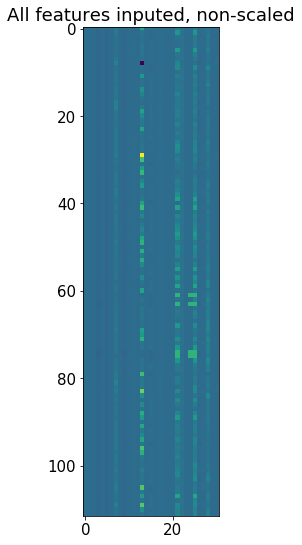

In [126]:
# Remove the NaNs from columns by replacing with the mean

# impute all NaNs in the array and replace with the mean
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(all_features_matrix_no_nan)

# replace all NaNs
all_features_new=imp.transform(all_features_matrix_no_nan)

plt.imshow(all_features_new)
plt.title('All features inputed, non-scaled')

print 'Data length'
print len(all_features_new)
print 'Resulting matrix shape'
print all_features_matrix_no_nan.shape

# Scale features of the feature matrix

Data length
112


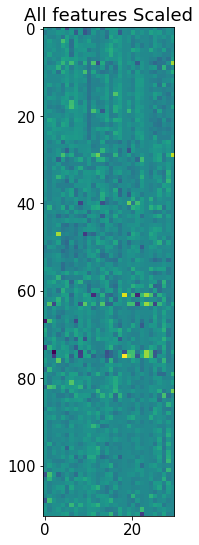

In [127]:
# Normalise all columns of the array
all_features_new_scaled = preprocessing.scale(all_features_new[:,1:])

# show the normalised data
plt.imshow(all_features_new_scaled)
plt.title('All features Scaled')

# show the length
print 'Data length'
print len(all_features_new_scaled)

In [128]:
# define the cell type label

cell_type = all_features_new[:,0]
print 'Cell types in numbers'
print cell_type

Cell types in numbers
[ 1.  1.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]


In [72]:
# define the number of features

n_features = len(all_features_new[0,:-1])
print 'Number of features'
print n_features

Number of features
30


# Predict the class of H18.06.368: WG1 vs WG4

Data length of 6 cases
86


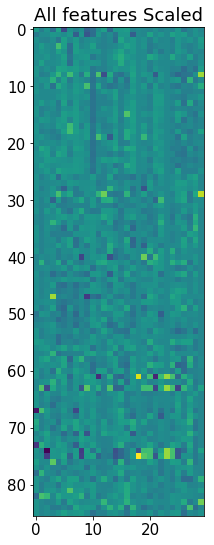

In [73]:
# Normalise all columns of the array - prepare the dataset for smaller size

all_features_new_scaled_6cases = all_features_new_scaled[:-26,:]

# show the normalised data
plt.imshow(all_features_new_scaled_6cases)
plt.title('All features Scaled')

# show the length
print 'Data length of 6 cases'
print len(all_features_new_scaled_6cases)

In [74]:
# define the cell type label for 6 cases

cell_type_6cases = all_features_new[:-26,0]
print 'Cell types in numbers'
print cell_type_6cases
print
print 'Length'
print len(cell_type_6cases)

Cell types in numbers
[ 1.  1.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]

Length
86


Random forest classification score: 1.0


Random forest classification performance: 0.860465116279
2 classes
Sum of feature importances: 1.0
Order of features
[28  5 17  7 15 27 13 26  2 12  9  8 19  0 23 20 14 10 22  4 21 11  6 24 25
  1  3 29 18 16]


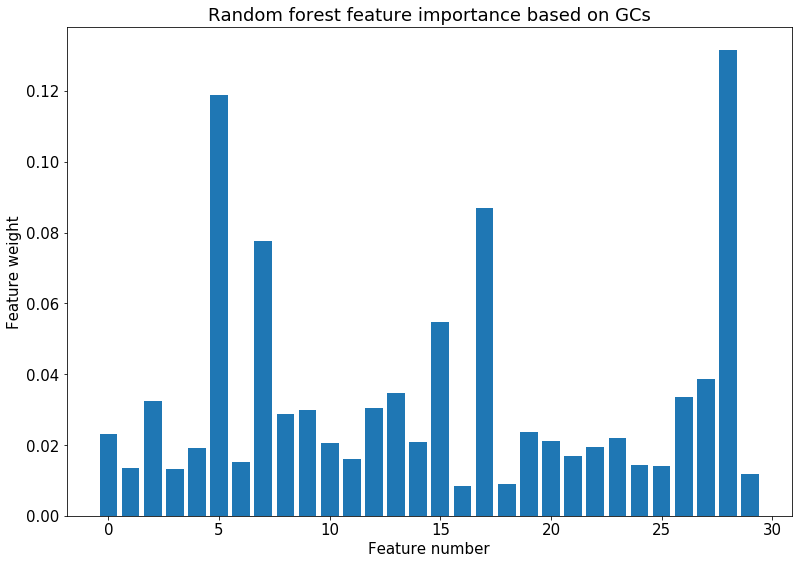

In [75]:
# create the random forest classifier trained on 6 cases


# process the cell type: WG1TS -> WG1 conversion
cell_type_14=np.array(cell_type_6cases)

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

#RandomForestClassifier(max_depth=None, random_state=0)
clf.fit(all_features_new_scaled_6cases, cell_type_14)

# get the scores of the trees and pring them
scores = clf.score(all_features_new_scaled_6cases, cell_type_14)
print 'Random forest classification score: ' + str(scores)


oob_error = clf.oob_score_
print '\n'
print 'Random forest classification performance: ' + str(oob_error)

print '2 classes'
feature_importance=clf.feature_importances_

# [np.flip(np.argsort(feature_importance),0)]
plt.bar(np.arange(0,n_features,1), feature_importance)


plt.title('Random forest feature importance based on GCs')
plt.xlabel('Feature number')
plt.ylabel('Feature weight')

#plt.xticks(np.arange(0,n_features,1),np.flip(np.argsort(feature_importance),0))

print 'Sum of feature importances: ' + str(np.sum(clf.feature_importances_))

print 'Order of features'
print np.flip(np.argsort(feature_importance),0)

# save the results in figures
#plt.bar(np.arange(0,n_features,1),log_p)
#plt.savefig('Random_forest_WG1WG1TS_WG4_weights_cortex.eps', format='eps', dpi=300)

### predict the H18.06.368 case using the created classifier

In [95]:
seven_case_data=all_features_new_scaled[-26:,:]

result=clf.predict(seven_case_data)
print'The result of H18.06.368 classification'
print result
print
n_wg1=len(np.where(result == 1)[0])
n_wg4=len(np.where(result == 4)[0])
print 'Probaility that H18.06.368 cells are WG1'
print float(n_wg1)/float((n_wg1+n_wg4))

The result of H18.06.368 classification
[ 1.  4.  1.  4.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  4.  1.  4.  4.
  1.  1.  1.  1.  4.  1.  4.  4.]

Probaility that H18.06.368 cells are WG1
0.692307692308


# Doing PCA on data: split based on patients

explained variance ratio (first two components): [ 0.19312502  0.13141914]


Text(0,0.5,'Principal component 2')

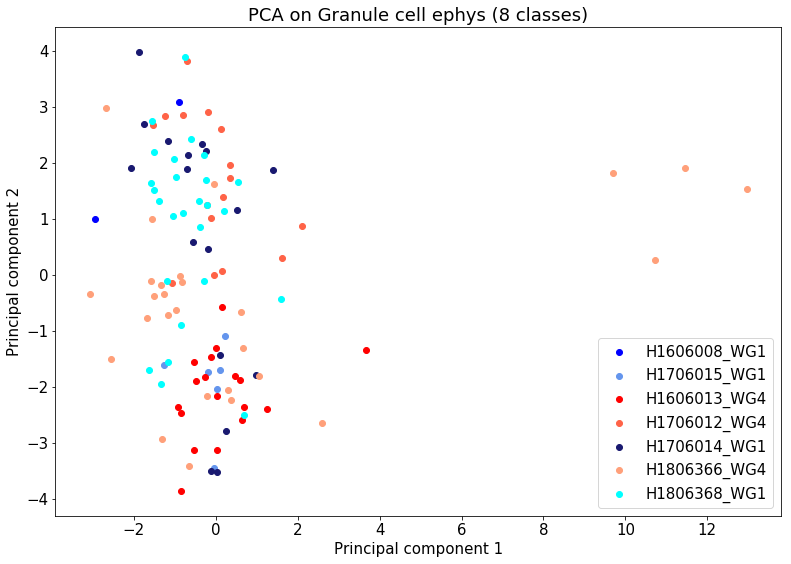

In [98]:

pca = PCA(n_components=2)
# get the cell positions in the new coordinates
X_r = pca.fit(all_features_new_scaled).transform(all_features_new_scaled)

# print the variance explained
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

# create the colors vectors
#colors = np.heaviside(cell_type-2,1)

# all indexes of WG
idx_1=np.zeros(1)
idx_2=np.zeros(1)
idx_3=np.zeros(1)
idx_4=np.zeros(1)
idx_5=np.zeros(1)
idx_6=np.zeros(1)
idx_7=np.zeros(1)
idx_8=np.zeros(1)


idx_1=np.where(patient_label==1)
idx_2=np.where(patient_label==2)
idx_3=np.where(patient_label==3)
idx_4=np.where(patient_label==4)
idx_5=np.where(patient_label==5)
idx_6=np.where(patient_label==6)
idx_7=np.where(patient_label==7)


fig, ax = plt.subplots()

plt.scatter(X_r[idx_1, 0],X_r[idx_1, 1],c='blue')
plt.scatter(X_r[idx_2, 0],X_r[idx_2, 1],c='cornflowerblue')
plt.scatter(X_r[idx_3, 0],X_r[idx_3, 1],c='red')
plt.scatter(X_r[idx_4, 0],X_r[idx_4, 1],c='tomato')
plt.scatter(X_r[idx_5, 0],X_r[idx_5, 1],c='midnightblue')
plt.scatter(X_r[idx_6, 0],X_r[idx_6, 1],c='lightsalmon')
plt.scatter(X_r[idx_7, 0],X_r[idx_7, 1],c='cyan')


plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA on Granule cell ephys (8 classes)')

plt.legend(['H1606008_WG1','H1706015_WG1','H1606013_WG4','H1706012_WG4','H1706014_WG1','H1806366_WG4','H1806368_WG1'])

plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

#plt.savefig('PCA_by_case.eps', format='eps', dpi=300)

# Doing PCA on data: split based on WG (2 classes)

explained variance ratio (first two components): [ 0.19312502  0.13141914]


Text(0,0.5,'Principal component 2')

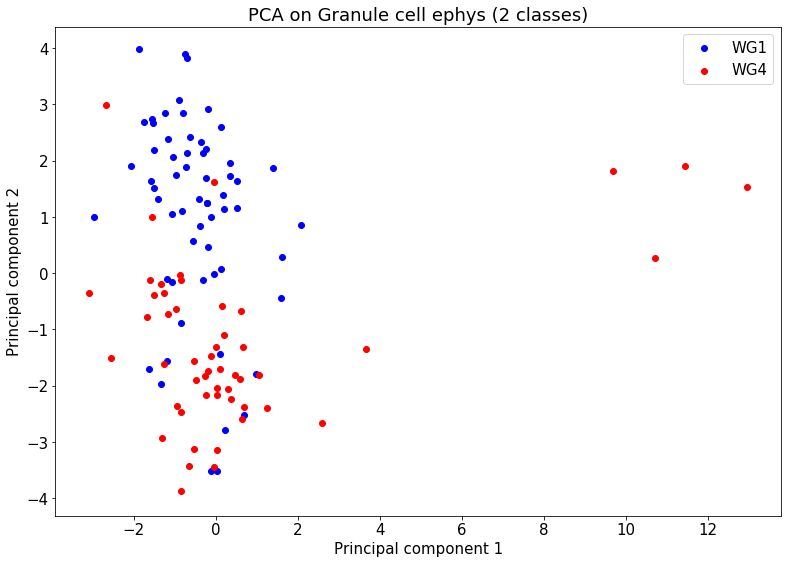

In [129]:

pca = PCA(n_components=2)
# get the cell positions in the new coordinates
X_r = pca.fit(all_features_new_scaled).transform(all_features_new_scaled)

# print the variance explained
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

# create the colors vectors
#colors = np.heaviside(cell_type-2,1)

# all indexes of WG
wg1_idx=np.zeros(1)
wg4_idx=np.zeros(1)

wg1_idx=np.where((cell_type==1))[0]
wg4_idx=np.where((cell_type==4))[0]


fig, ax = plt.subplots()

plt.scatter(X_r[wg1_idx, 0],X_r[wg1_idx, 1],c='blue')
plt.scatter(X_r[wg4_idx, 0],X_r[wg4_idx, 1],c='red')

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA on Granule cell ephys (2 classes)')
plt.legend(['WG1','WG4'])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

#plt.savefig('PCA_3_classes.eps', format='eps', dpi=300)

# Doing PCA on data: split based on WG (2 classes) + model cells

explained variance ratio (first two components): [ 0.19312502  0.13141914]


Text(0,0.5,'Principal component 2')

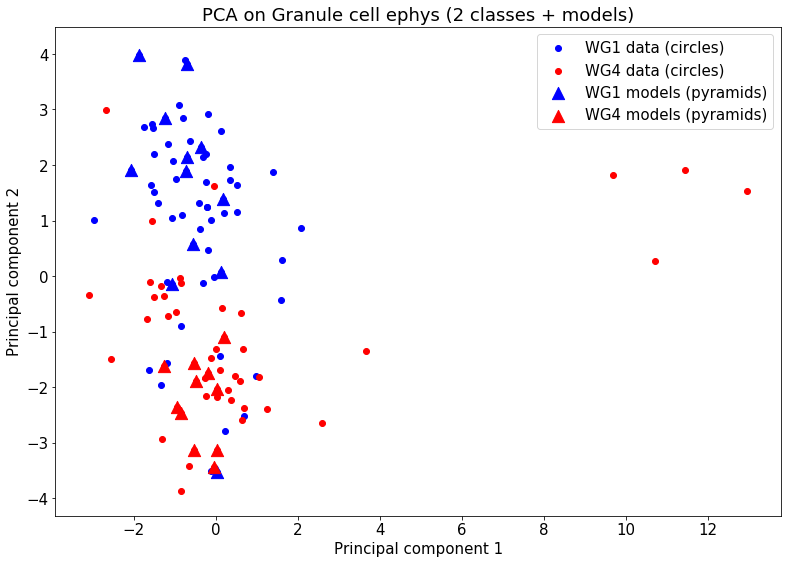

In [152]:
pca = PCA(n_components=2)
# get the cell positions in the new coordinates
X_r = pca.fit(all_features_new_scaled).transform(all_features_new_scaled)

# print the variance explained
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

# create the colors vectors
#colors = np.heaviside(cell_type-2,1)

# all indexes of WG
wg1_idx=np.zeros(1)
wg4_idx=np.zeros(1)
wg1_model_idx=np.zeros(1)
wg4_model_idx=np.zeros(1)

wg1_idx=np.where((cell_type==1))[0]
wg4_idx=np.where((cell_type==4))[0]
wg1_model_idx=wg1_best_idx
wg4_model_idx=wg4_best_idx


fig, ax = plt.subplots()

# plot the main data
plt.scatter(X_r[wg1_idx, 0],X_r[wg1_idx, 1],c='blue')
plt.scatter(X_r[wg4_idx, 0],X_r[wg4_idx, 1],c='red')
# plot the model cells
plt.scatter(X_r[wg1_model_idx, 0],X_r[wg1_model_idx, 1],c='blue',marker='^',s=150)
plt.scatter(X_r[wg4_model_idx, 0],X_r[wg4_model_idx, 1],c='red',marker='^',s=150)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA on Granule cell ephys (2 classes + models)')
plt.legend(['WG1 data (circles)','WG4 data (circles)','WG1 models (pyramids)','WG4 models (pyramids)'])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

#plt.savefig('PCA_3_classes.eps', format='eps', dpi=300)

# Doing tSNE on data: split based on WG (2 classes) + model cells

Ephys dataset, perplexity=30 in 1.6 sec


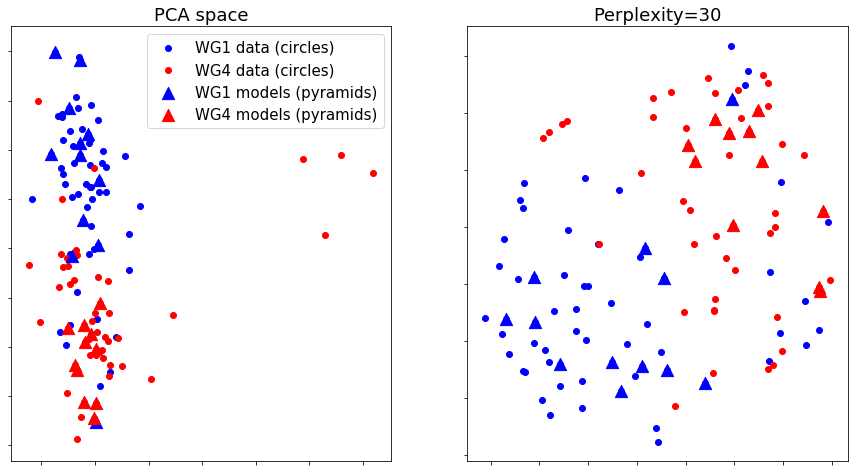

In [155]:


# Dataset description
#n_samples = 119

# Aiming to project to 2 componenets
n_components = 2

(fig, subplots) = plt.subplots(1, 2, figsize=(15, 8))
perplexities = [30]

pca = PCA(n_components=30)
# get the cell positions in the new coordinates
X_r = pca.fit(all_features_new_scaled).transform(all_features_new_scaled)


X = X_r[:,:]
y = cell_type_14

idx_1=np.where(cell_type==1)
idx_2=np.where(cell_type==4)
wg1_model_idx=wg1_best_idx
wg4_model_idx=wg4_best_idx



ax = subplots[0]

ax.scatter(X_r[idx_1, 0],X_r[idx_1, 1],c='blue')
ax.scatter(X_r[idx_2, 0],X_r[idx_2, 1],c='red')

# models
ax.scatter(X_r[wg1_model_idx, 0],X_r[wg1_model_idx, 1],c='blue',marker='^',s=150)
ax.scatter(X_r[wg4_model_idx, 0],X_r[wg4_model_idx, 1],c='red',marker='^',s=150)


ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
ax.set_title('PCA space')

# split by case type
ax.legend(['WG1 data (circles)','WG4 data (circles)','WG1 models (pyramids)','WG4 models (pyramids)'])


for i, perplexity in enumerate(perplexities):
    ax = subplots[i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity, metric='cosine',n_iter=20000)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("Ephys dataset, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)

    # plot different cells with different labels
    
    ax.scatter(Y[idx_1, 0],Y[idx_1, 1],c='blue')
    ax.scatter(Y[idx_2, 0],Y[idx_2, 1],c='red')
    ax.scatter(Y[wg1_model_idx, 0],Y[wg1_model_idx, 1],c='blue',marker='^',s=150)
    ax.scatter(Y[wg4_model_idx, 0],Y[wg4_model_idx, 1],c='red',marker='^',s=150)

    
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

    
#plt.savefig('tSNE_perplexity_20_CASE.eps', format='eps', dpi=300)

#plt.show()

# Pairwise features comparison

Indexes of wg1 and wg4 cells

[  0   1  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111]

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84
 85]

0.0727736525534
0.038117124115
0.0868348496205
0.349688118712
0.244657293711
1.35267261276e-09
0.367835050404


/Users/Anatoly/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:1872: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:1879: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:1887: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:1888: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


5.6366892221e-08
0.000343367708034
0.155075035565
0.000519988306547
0.00209125324888
0.00584639939736
0.0754200634209
0.0860811735099
0.016222168414
0.441024245449
3.25376863491e-10
0.420740619596
0.0352319848137
0.0223042863016
0.671697462592
0.532672789984
0.00060701856409
0.0883588337091
0.552460654912
3.24857357809e-05
0.0143953160231
2.63560766792e-10
0.0143953160231


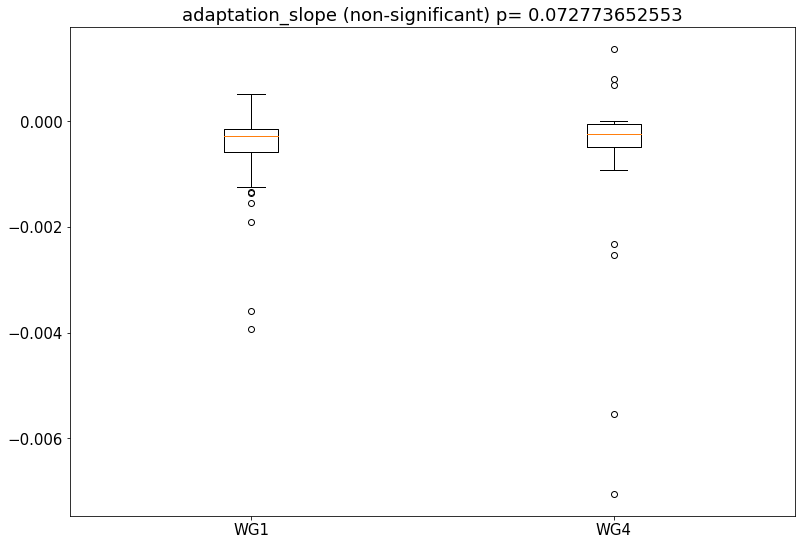

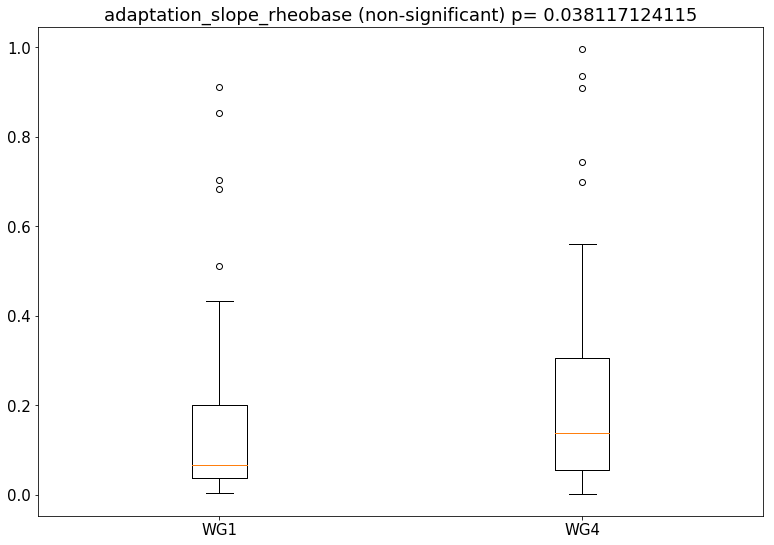

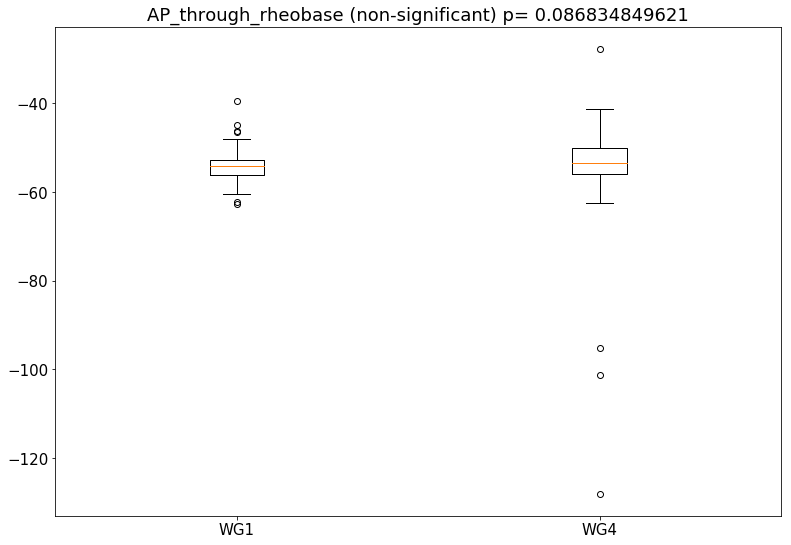

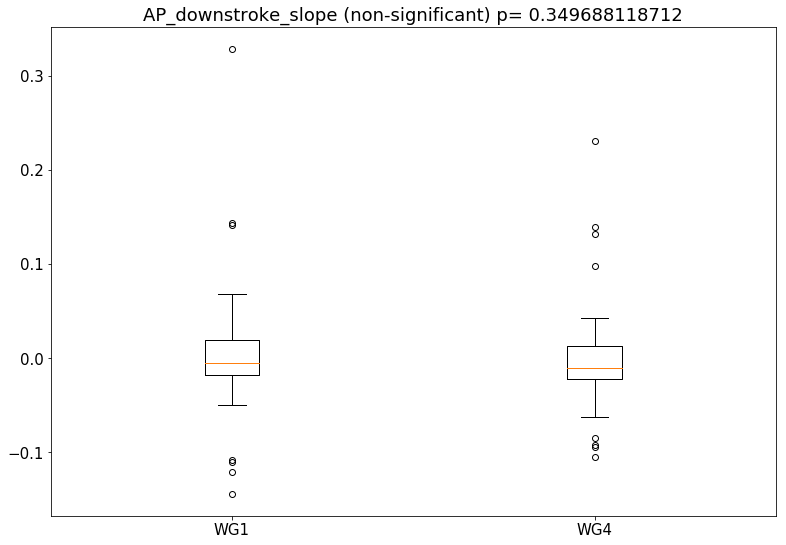

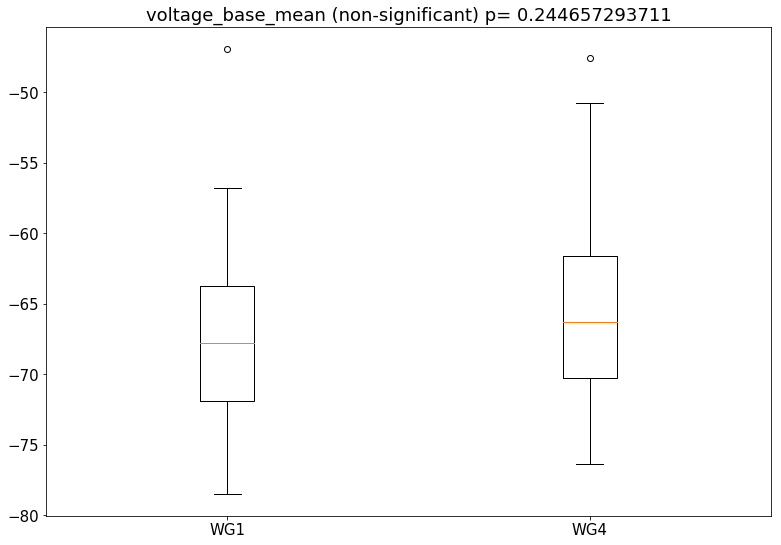

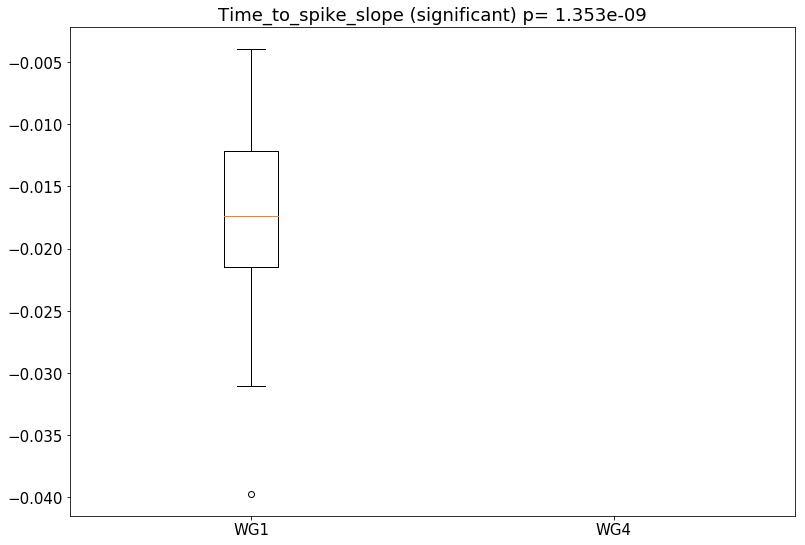

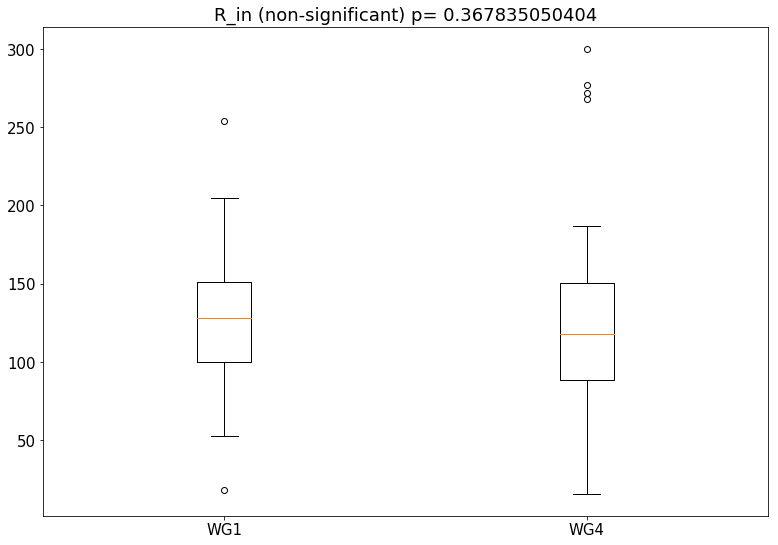

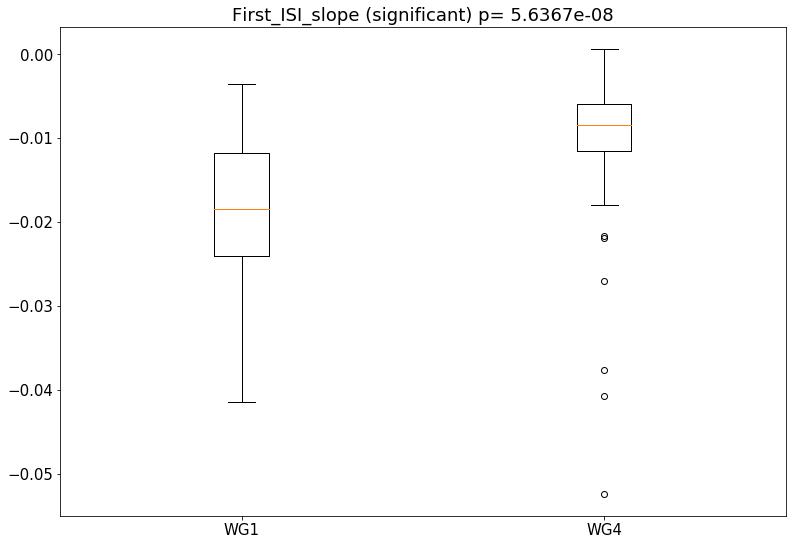

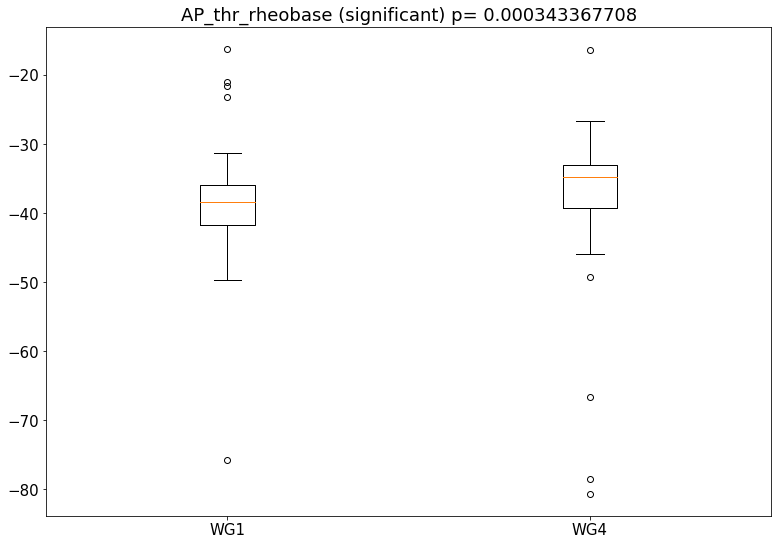

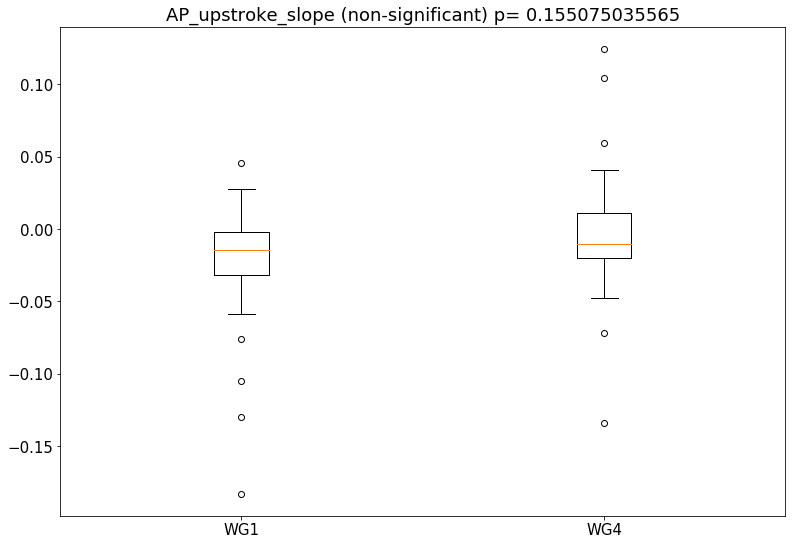

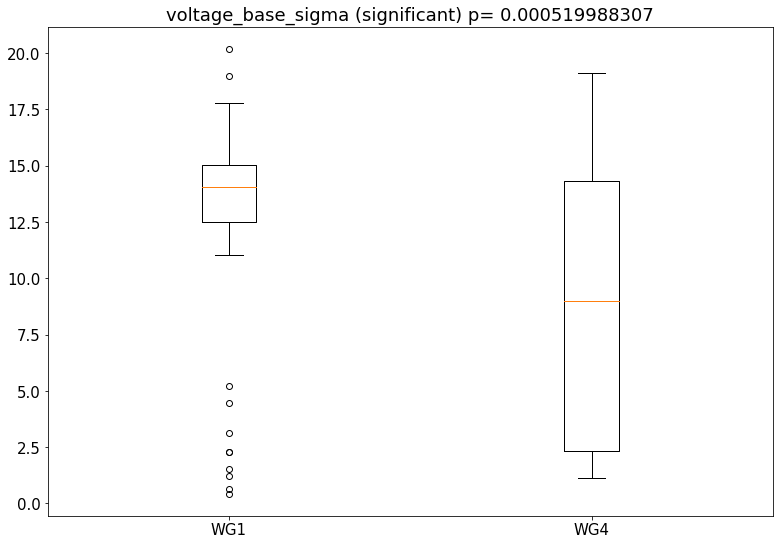

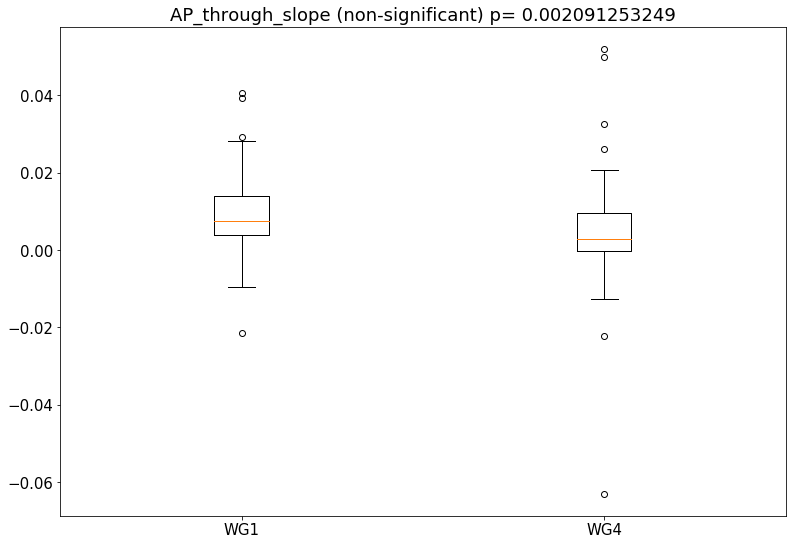

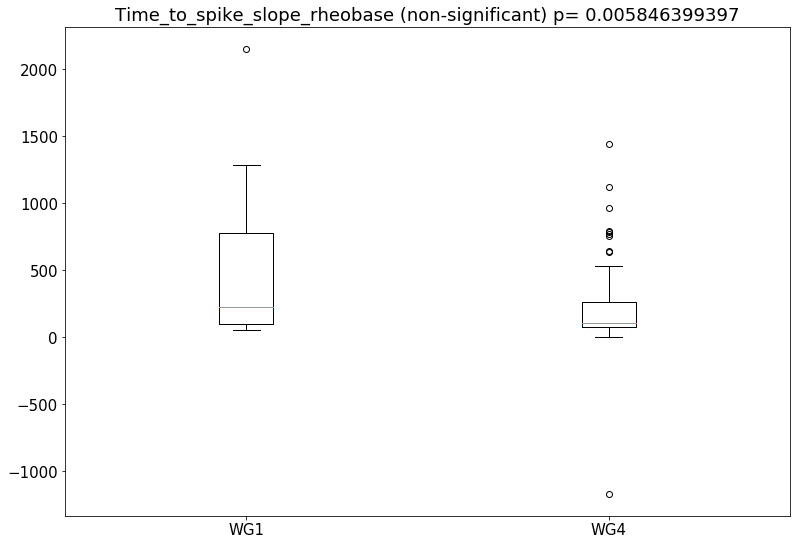

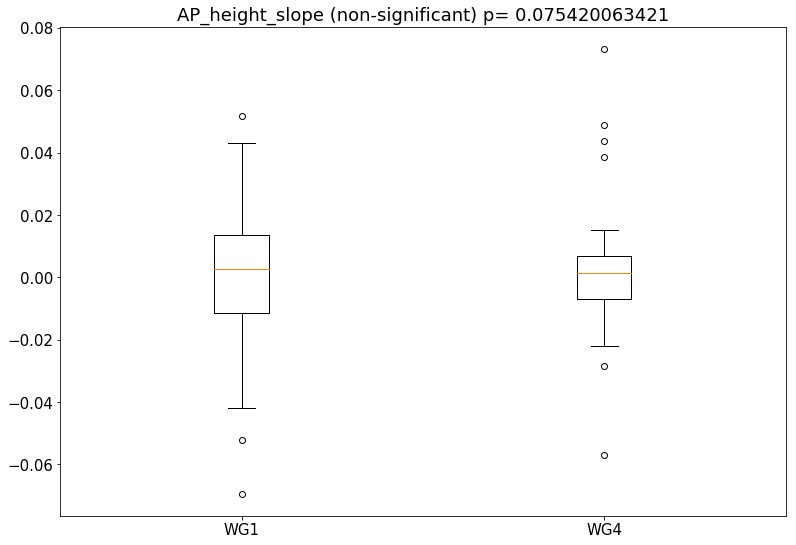

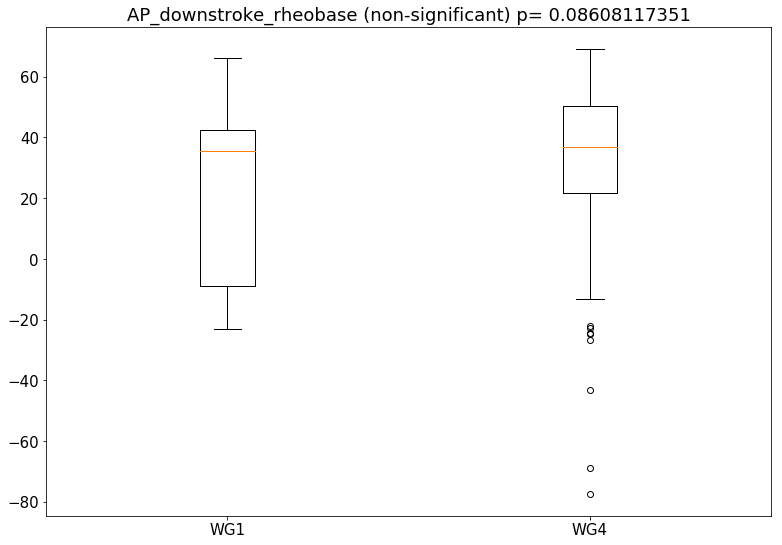

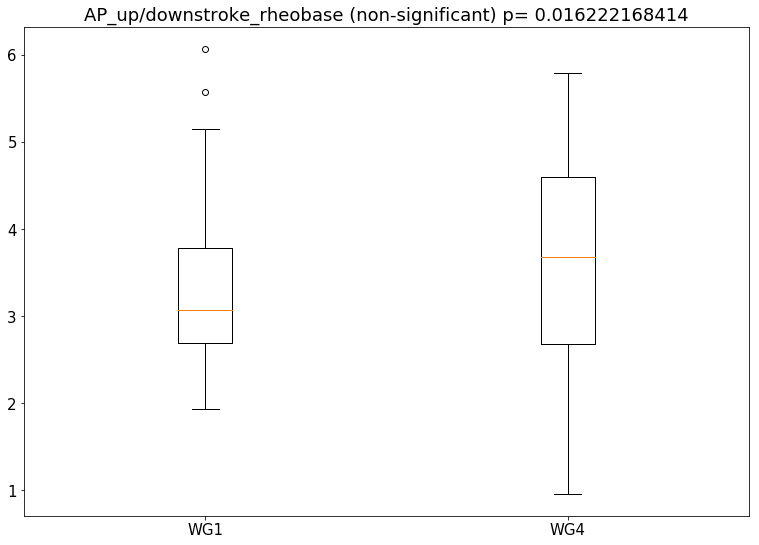

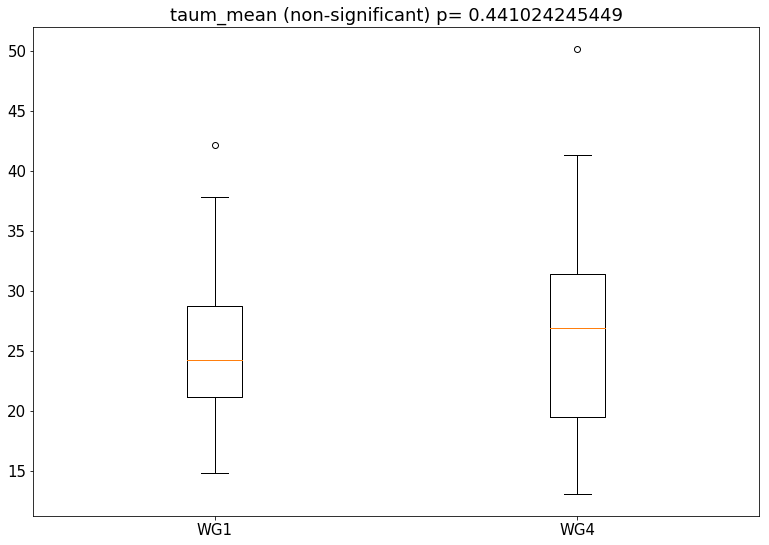

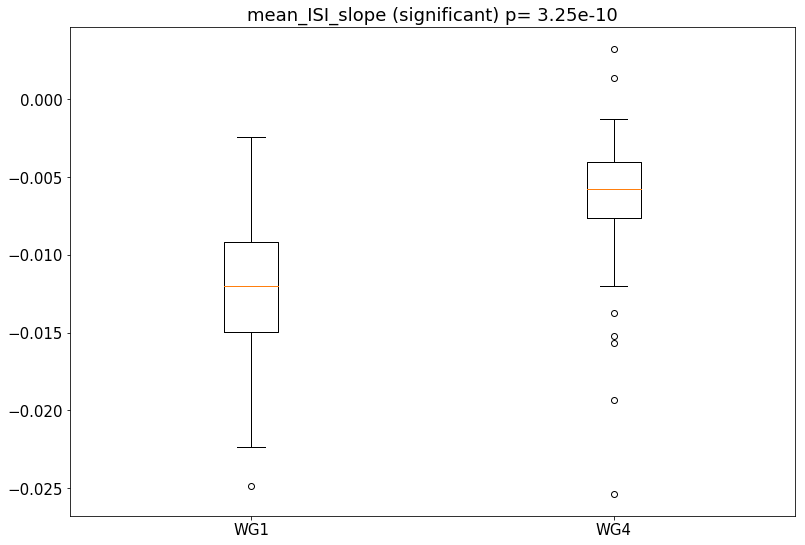

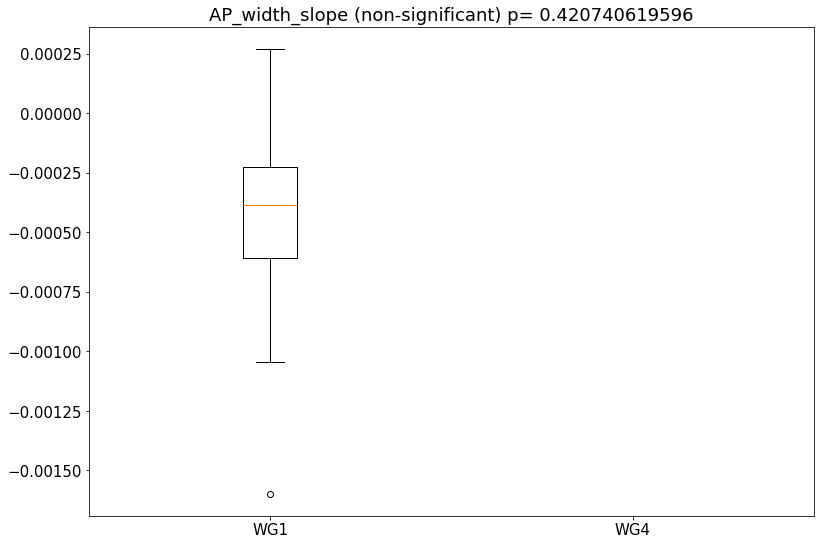

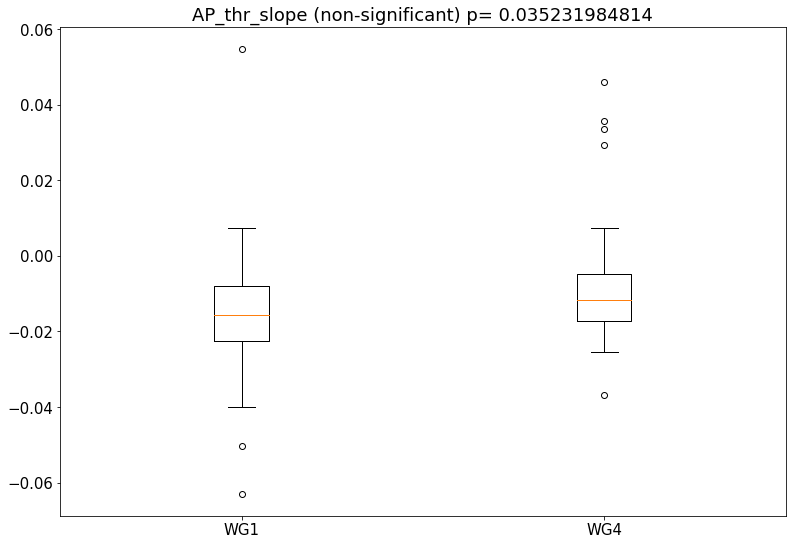

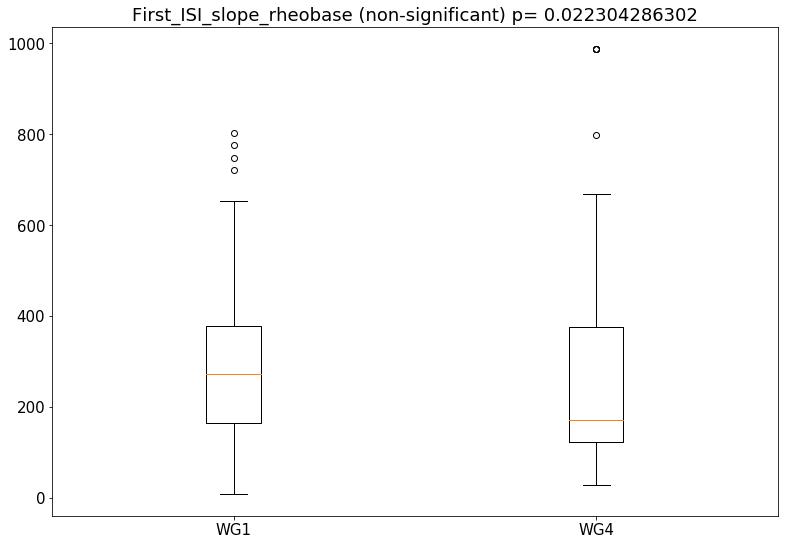

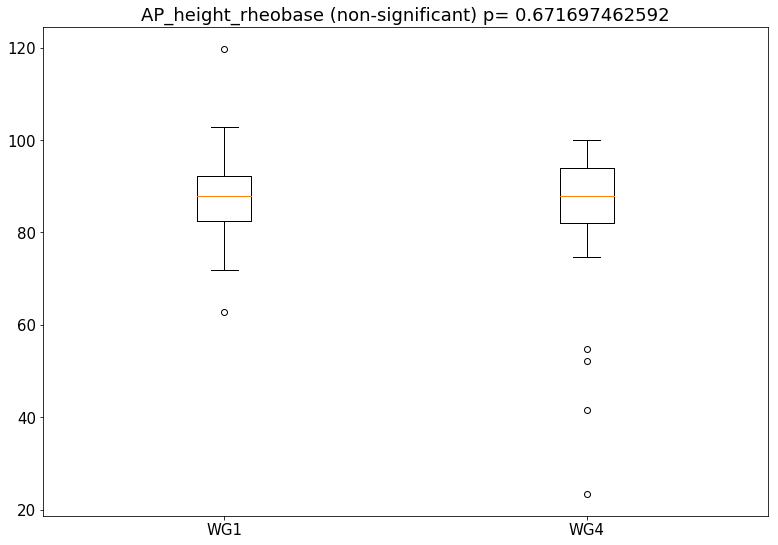

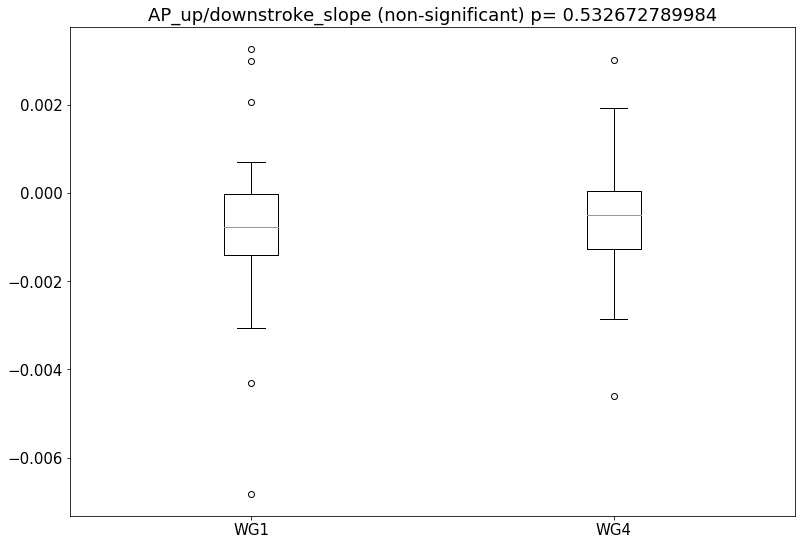

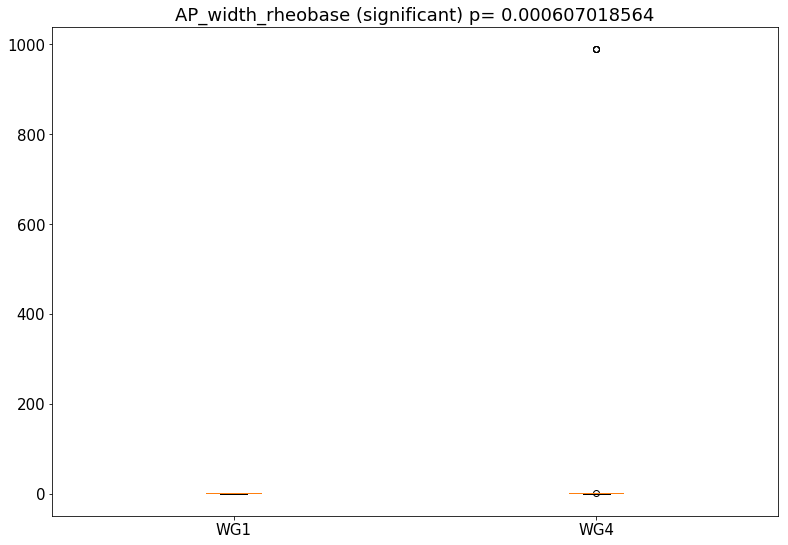

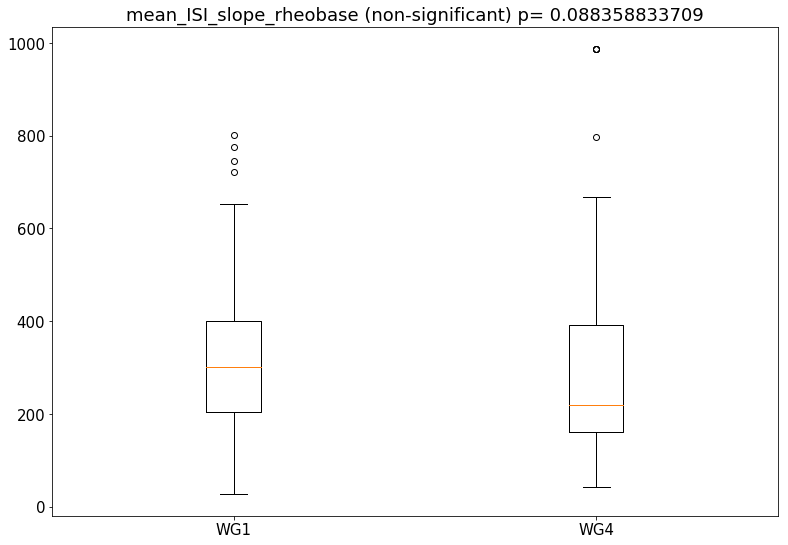

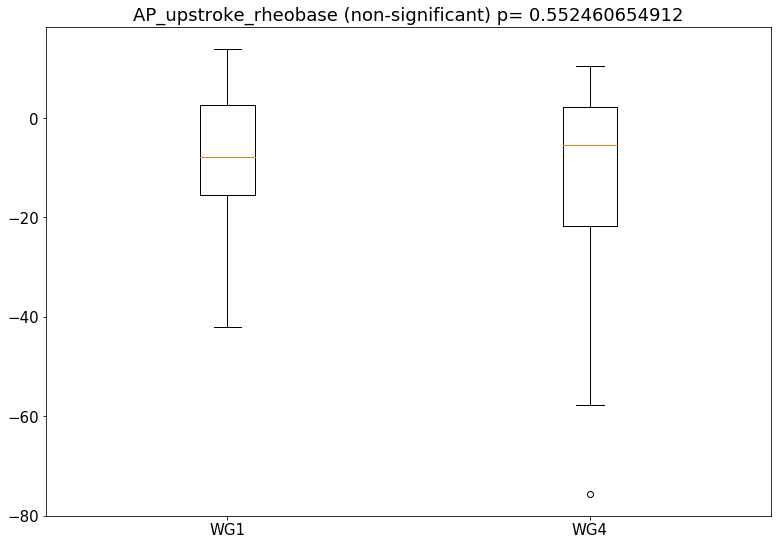

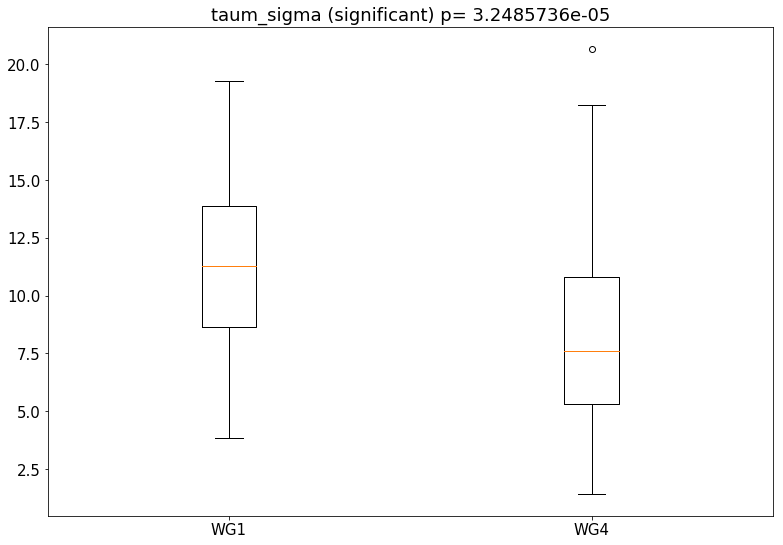

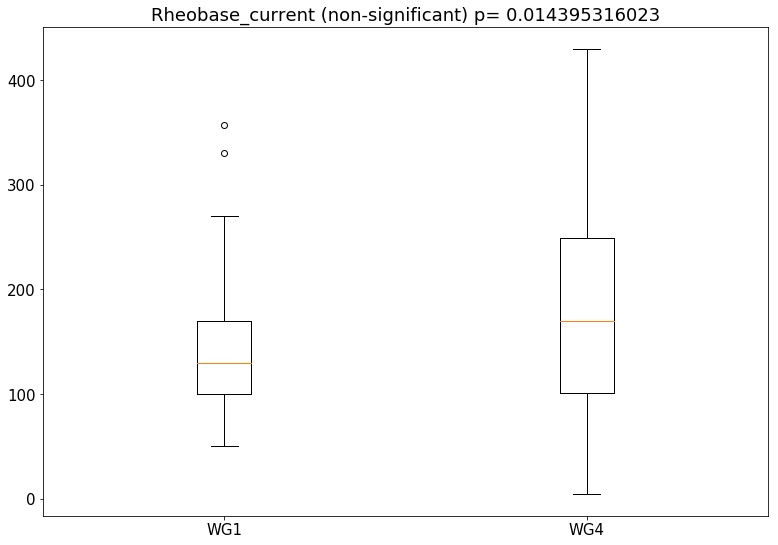

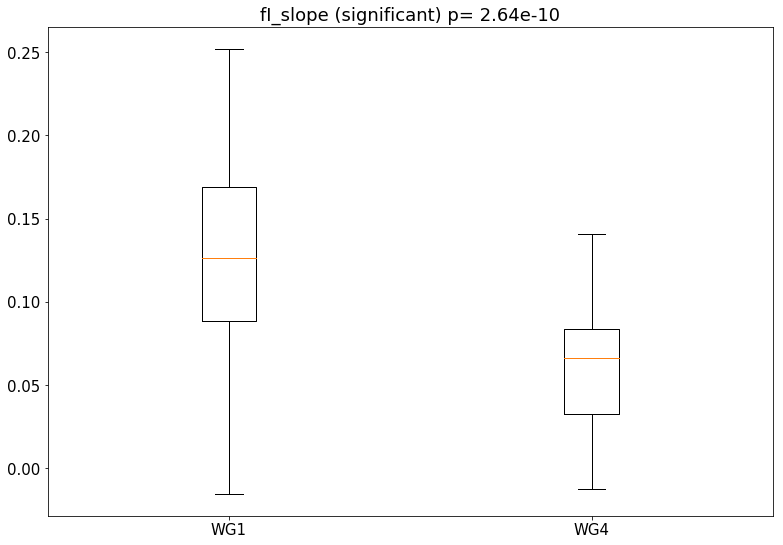

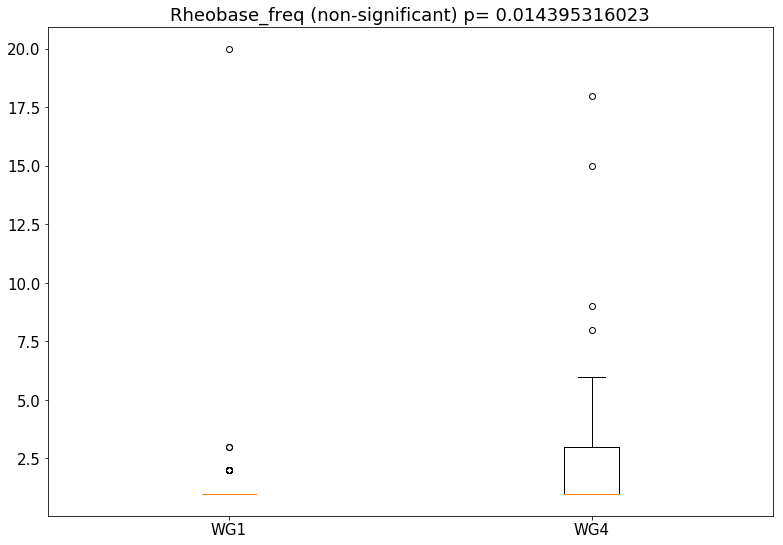

In [104]:
# find indexes of wg1 and wg4 neurons

wg1_idx=np.where(all_features_matrix_no_nan[:,0] == 1)[0]
wg4_idx=np.where(all_features_matrix_no_nan[:,0] == 4)[0]

# sign level
alpha_level=0.05

print 'Indexes of wg1 and wg4 cells'
print
print wg1_idx
print
print wg4_idx
print

# compare all features and compute p_values

p_values=np.zeros(n_features)

# plot the box plots for all cells

for i in np.arange(n_features):

    feature_1=all_features_matrix_no_nan[wg1_idx,i+1]
    feature_2=all_features_matrix_no_nan[wg4_idx,i+1]

    d,p=stats.ks_2samp(feature_1,feature_2)
    print p
    # record the p_values
    p_values[i]=p

    # plot the results        
    fig, ax = plt.subplots()
    labels=['WG1','WG4']
#    plt.violinplot([feature_1,feature_2])
    plt.boxplot([feature_1,feature_2])
    if p<alpha_level/n_features:
        plt.title(feature_names[i]+str(' (significant)') +str(' p= ') +str(np.round(p,12)))
    else:
        plt.title(feature_names[i]+str(' (non-significant)') +str(' p= ') +str(np.round(p,12)))
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    # save figure part
#   plt.savefig(str(str(feature_names[i])+'.eps'), format='eps', dpi=300)

In [169]:
# test code

print feature_1[0]

print feature_2[0]

1.18626374707
1.2356913622


AP_width_rheobase
[ 1.18626375  1.38397434  0.9885531   0.88969781  0.88969778  0.88969775
  1.08740839  0.88969779  1.23569137  0.79084248  1.18626372  0.8896978
  0.79084251  0.79084246  0.79084242  0.88969781  0.88969779  1.28511901
  1.48282966  0.98855311  1.23569135  1.08740842  1.18626372  1.48282966
  1.28511902  1.08740846  1.1862637   1.0874084   1.18626375  1.2356914
  1.08740845  1.18626372  1.48282968  1.0874084   1.48282964  0.79084246
  1.38397432  0.76612864  1.08740843  0.98855311  0.98855313  0.88969778
  0.88969775  0.88969775  0.98855308  0.88969781  0.88969778  0.88969782
  0.88969779  0.88969777  0.9885531   1.0874084   1.08740837  1.0874084
  1.08740838  0.98855309  1.08740842  1.28511903  1.18626372  0.98855308
  1.06269459]

[  1.23569136e+00   1.21097754e+00   1.23569137e+00   1.18626371e+00
   1.18626372e+00   8.89697777e-01   1.48282964e+00   2.71852099e+00
   1.48282962e+00   1.23569139e+00   1.48282963e+00   1.48282961e+00
   1.48282967e+00   1.48282961e+0

{'boxes': [<matplotlib.lines.Line2D at 0x1a2cb03f90>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2cb03390>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a2cb11b50>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a2cb11750>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1a2cb03d50>,
  <matplotlib.lines.Line2D at 0x1a2caf8790>]}

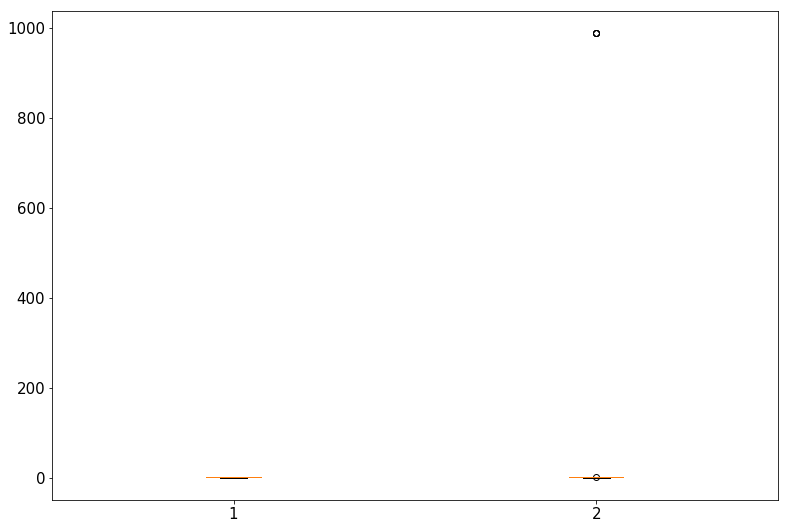

In [170]:
# test code (check the visualisation)

i=23
print feature_names[i]

feature_1=all_features_matrix_no_nan[wg1_idx,i+1]
feature_2=all_features_matrix_no_nan[wg4_idx,i+1]

print feature_1
print
print feature_2

plt.boxplot([feature_1,feature_2])

p_values of 30 features:30 features
[  7.27736526e-02   3.81171241e-02   8.68348496e-02   3.49688119e-01
   2.44657294e-01   1.35267261e-09   3.67835050e-01   5.63668922e-08
   3.43367708e-04   1.55075036e-01   5.19988307e-04   2.09125325e-03
   5.84639940e-03   7.54200634e-02   8.60811735e-02   1.62221684e-02
   4.41024245e-01   3.25376863e-10   4.20740620e-01   3.52319848e-02
   2.23042863e-02   6.71697463e-01   5.32672790e-01   6.07018564e-04
   8.83588337e-02   5.52460655e-01   3.24857358e-05   1.43953160e-02
   2.63560767e-10   1.43953160e-02]




([<matplotlib.axis.XTick at 0x1a1e37f290>,
 <a list of 30 Text xticklabel objects>)

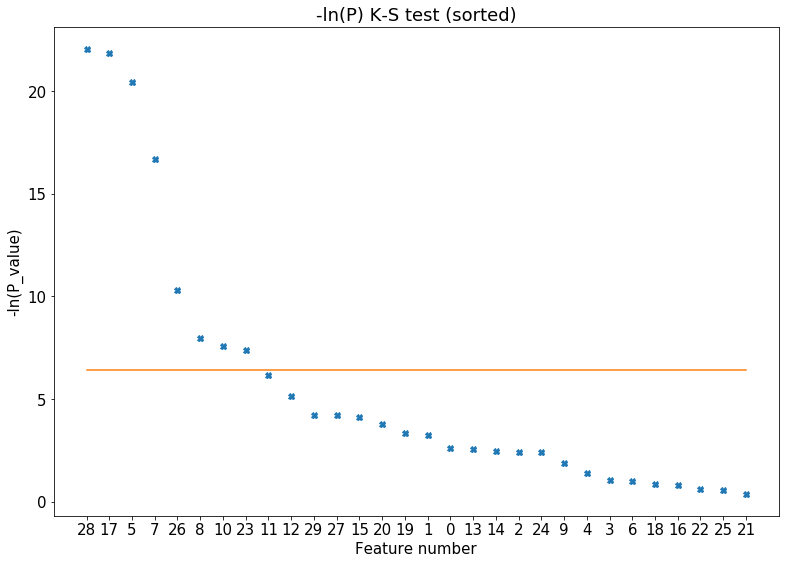

In [106]:
# p-values order is the same for all features and further analysis

print 'p_values of 30 features:' +str(len(p_values)) +str(' features')
print p_values
print '\n'

# significance level
alpha_level=0.05
p_level=alpha_level/n_features
sign_level=np.zeros(n_features)
sign_level[:]=-np.log(p_level)
log_p=-np.log(p_values) # initial log_p


plt.plot(np.arange(0,n_features,1),log_p[np.flip(np.argsort(-np.log(p_values)),0)],'X',np.arange(0,n_features,1),sign_level)
plt.title('-ln(P) K-S test (sorted)')
plt.ylabel('-ln(P_value)')
plt.xlabel('Feature number')

# xticks
plt.xticks(np.arange(0,n_features,1),np.flip(np.argsort(-np.log(p_values)),0))

#print np.flip(np.argsort(-np.log(p_values)),0)

# Plot p-values as a bar plot

Text(0.5,1,'-ln(P) K-S test (unsorted)')

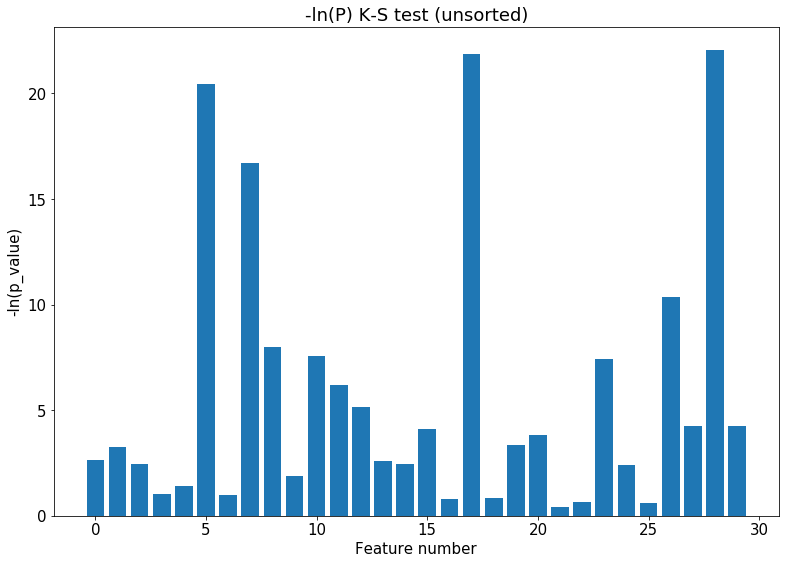

In [107]:
# PLOT p-values as a bar plot

# p-values order is different from all other features

# significance level
p_level=alpha_level/n_features
sign_level=np.zeros(n_features)
sign_level[:]=-np.log(p_level)
log_p=-np.log(p_values) # initial log_p


plt.bar(np.arange(0,n_features,1),log_p)
plt.ylabel('-ln(p_value)')
plt.xlabel('Feature number')
plt.title('-ln(P) K-S test (unsorted)')

# save figure to eps
#plt.savefig('all_features_KS_bonferoni.eps',format='eps',dpi=300)

# Plot 10 most distinct features (p-values)

Names of the important features:


fI_slope
mean_ISI_slope
Time_to_spike_slope
First_ISI_slope
taum_sigma
AP_thr_rheobase
voltage_base_sigma
AP_width_rheobase
AP_through_slope
Time_to_spike_slope_rheobase


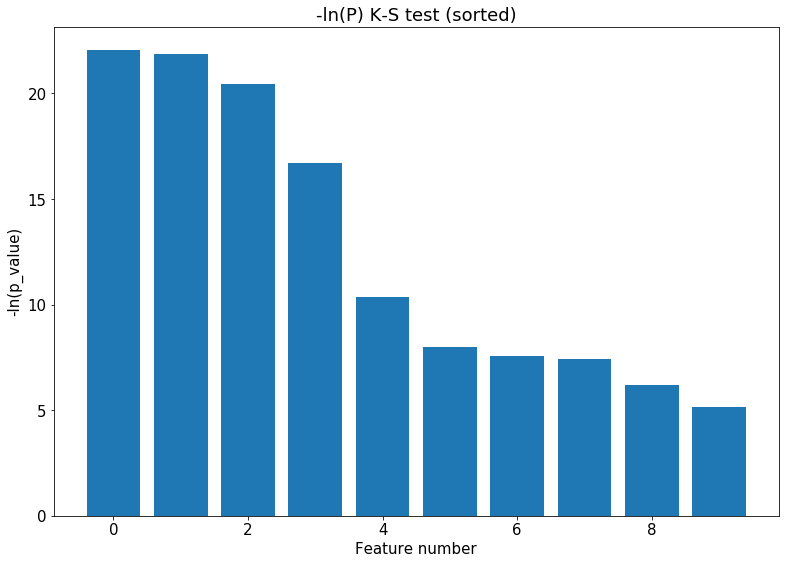

In [120]:
feature_order_idx=np.flip(np.argsort(-np.log(p_values)),0)
feature_to_show=10


plt.bar(np.arange(0,feature_to_show,1),log_p[feature_order_idx[0:feature_to_show]])
plt.ylabel('-ln(p_value)')
plt.xlabel('Feature number')
plt.title('-ln(P) K-S test (sorted)')

# show the feature order idx
print 'Names of the important features:'
print '\n'
for i in range(feature_to_show):
    print feature_names[feature_order_idx[i]]

# save figure to eps
#plt.savefig('all_features_KS_bonferoni_10most_significant.eps',format='eps',dpi=300)

# Show features in the PCA space

Text(0.5,1,'All features in PCA-space')

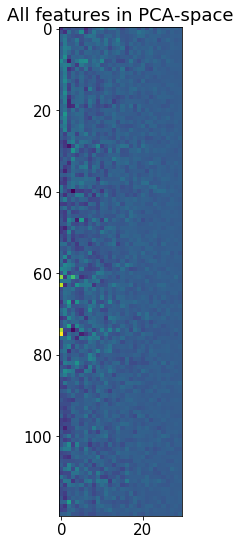

In [106]:
pca = PCA(n_components=30)
# get the cell positions in the new coordinates, X_r - the dataset in the PCA space
X_r = pca.fit(all_features_new_scaled).transform(all_features_new_scaled)

# show all features projected in the PCA space

plt.imshow(X_r)
plt.title('All features in PCA-space')

# Random forest classification for 2 classes

Random forest classification score: 1.0


Random forest classification performance: 0.8125
2 classes
Sum of feature importances: 1.0
Order of features
[28  5 17  7 15 27 26 10 23  2 12 11  0 19 13 20 22 24  8  9 16 25  4  1 29
 14 18 21  3  6]


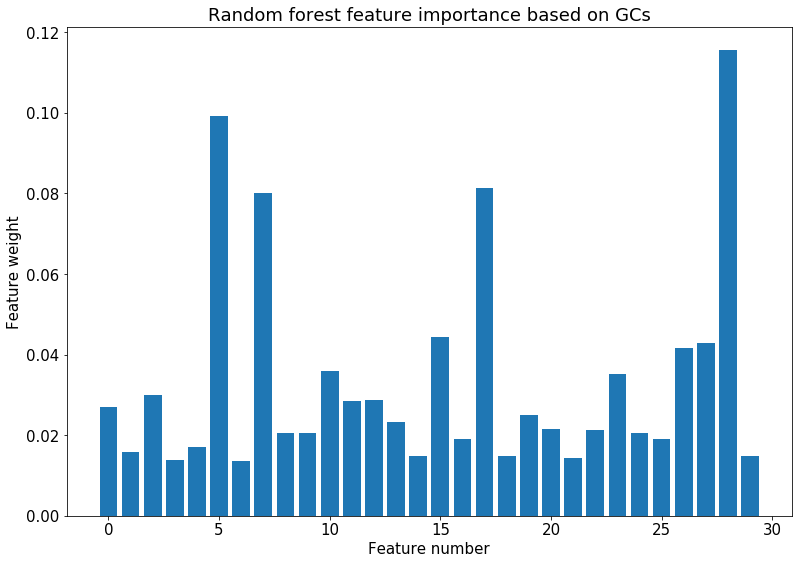

In [109]:
# do random forest classifier on original data

# CELL_TYPES FOR WG1+WG1TS, WG4

# process the cell type: WG1TS -> WG1 conversion
cell_type_14=np.array(cell_type)
#cell_type_14[np.where(cell_type_14 == 11)]=1

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

#RandomForestClassifier(max_depth=None, random_state=0)
clf.fit(all_features_new_scaled, cell_type_14)

# get the scores of the trees and pring them
scores = clf.score(all_features_new_scaled, cell_type_14)
print 'Random forest classification score: ' + str(scores)


oob_error = clf.oob_score_
print '\n'
print 'Random forest classification performance: ' + str(oob_error)

print '2 classes'
feature_importance=clf.feature_importances_

# [np.flip(np.argsort(feature_importance),0)]
plt.bar(np.arange(0,n_features,1), feature_importance)


plt.title('Random forest feature importance based on GCs')
plt.xlabel('Feature number')
plt.ylabel('Feature weight')

#plt.xticks(np.arange(0,n_features,1),np.flip(np.argsort(feature_importance),0))

print 'Sum of feature importances: ' + str(np.sum(clf.feature_importances_))

print 'Order of features'
print np.flip(np.argsort(feature_importance),0)


# save the results in figures
#plt.bar(np.arange(0,n_features,1),log_p)
#plt.savefig('Random_forest_WG1WG1TS_WG4_weights_cortex.eps', format='eps', dpi=300)

# Show the feature importance of 10 most important features

Names of the important features:


fI_slope
Time_to_spike_slope
mean_ISI_slope
First_ISI_slope
AP_up/downstroke_rheobase
Rheobase_current
taum_sigma
voltage_base_sigma
AP_width_rheobase
AP_through_rheobase


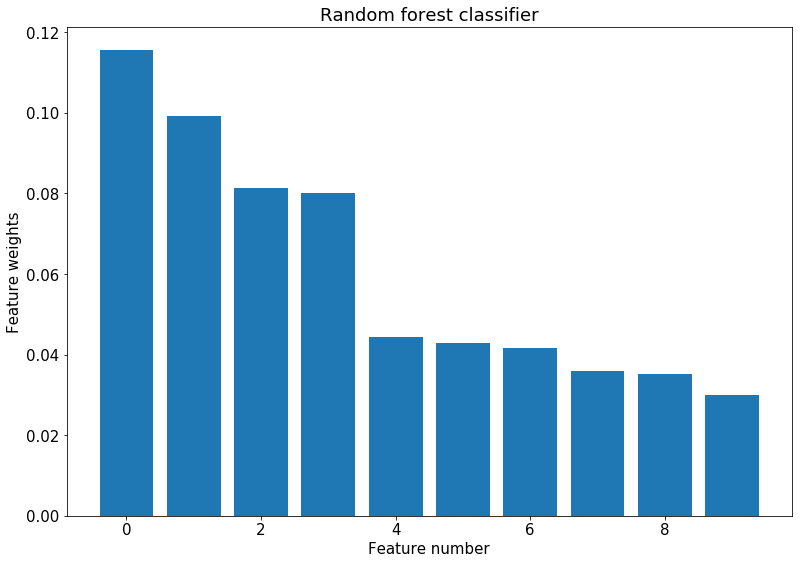

In [110]:

# feature order
feature_order_idx=np.flip(np.argsort(feature_importance),0)
feature_to_show=10


plt.bar(np.arange(0,feature_to_show,1),feature_importance[feature_order_idx[0:feature_to_show]])
plt.ylabel('Feature weights')
plt.xlabel('Feature number')
plt.title('Random forest classifier')

# show the feature order idx
print 'Names of the important features:'
print '\n'
for i in range(feature_to_show):
    print feature_names[feature_order_idx[i]]

# save figure to eps
#plt.savefig('all_features_random_forest_10_largest_cortex.eps',format='eps',dpi=300)

# Classify the features dataset in the original feature space

('DecisionTree with features', [0, 1], 'has a score of', 1.0)
('RandomForest with 200 estimators with features', [0, 1], 'has a score of', 1.0)
('ExtraTrees with 200 estimators with features', [0, 1], 'has a score of', 1.0)
('AdaBoost with 200 estimators with features', [0, 1], 'has a score of', 1.0)
('DecisionTree with features', [0, 2], 'has a score of', 1.0)
('RandomForest with 200 estimators with features', [0, 2], 'has a score of', 1.0)
('ExtraTrees with 200 estimators with features', [0, 2], 'has a score of', 1.0)
('AdaBoost with 200 estimators with features', [0, 2], 'has a score of', 1.0)
('DecisionTree with features', [2, 3], 'has a score of', 1.0)
('RandomForest with 200 estimators with features', [2, 3], 'has a score of', 1.0)
('ExtraTrees with 200 estimators with features', [2, 3], 'has a score of', 1.0)
('AdaBoost with 200 estimators with features', [2, 3], 'has a score of', 1.0)


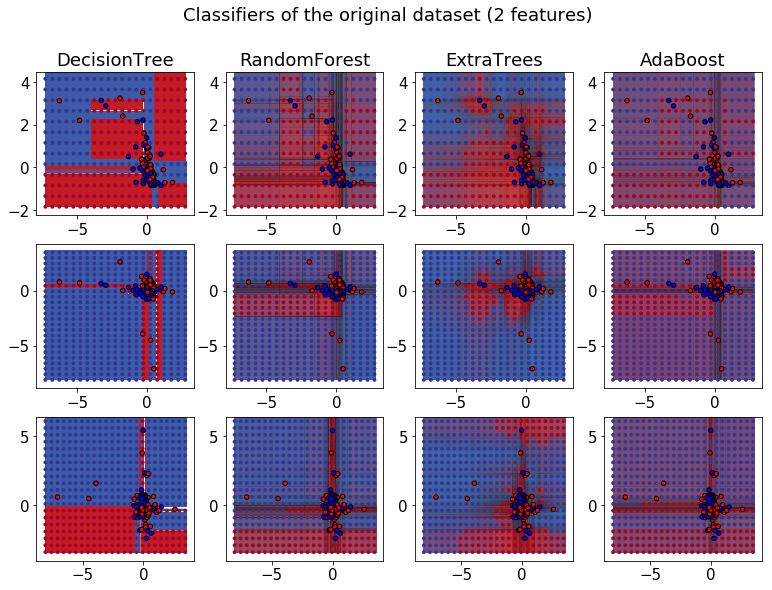

In [111]:

# Parameters
n_classes = len(np.unique(cell_type))
n_estimators = 200
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 15  # fix the seed on each iteration


plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features

        X = all_features_new_scaled[:, pair]
        y = cell_type_14

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(
            ".")[-1][:-2][:-len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(
                len(model.estimators_))
        print(model_details + " with features", pair,
              "has a score of", scores)

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                         yy_coarser.ravel()]
                                         ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                                c=Z_points_coarser, cmap=cmap,
                                edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(X[:, 0], X[:, 1], c=y,
                    cmap=ListedColormap(['b','r']),
                    edgecolor='k', s=20)
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers of the original dataset (2 features)")
plt.axis("tight")

plt.show()

# Classify the features dataset after PCA: 2 classes

('DecisionTree with features', [0, 1], 'has a score of', 1.0)
('RandomForest with 200 estimators with features', [0, 1], 'has a score of', 1.0)
('ExtraTrees with 200 estimators with features', [0, 1], 'has a score of', 1.0)
('AdaBoost with 200 estimators with features', [0, 1], 'has a score of', 1.0)
('DecisionTree with features', [0, 2], 'has a score of', 1.0)
('RandomForest with 200 estimators with features', [0, 2], 'has a score of', 1.0)
('ExtraTrees with 200 estimators with features', [0, 2], 'has a score of', 1.0)
('AdaBoost with 200 estimators with features', [0, 2], 'has a score of', 1.0)
('DecisionTree with features', [2, 3], 'has a score of', 1.0)
('RandomForest with 200 estimators with features', [2, 3], 'has a score of', 1.0)
('ExtraTrees with 200 estimators with features', [2, 3], 'has a score of', 1.0)
('AdaBoost with 200 estimators with features', [2, 3], 'has a score of', 1.0)


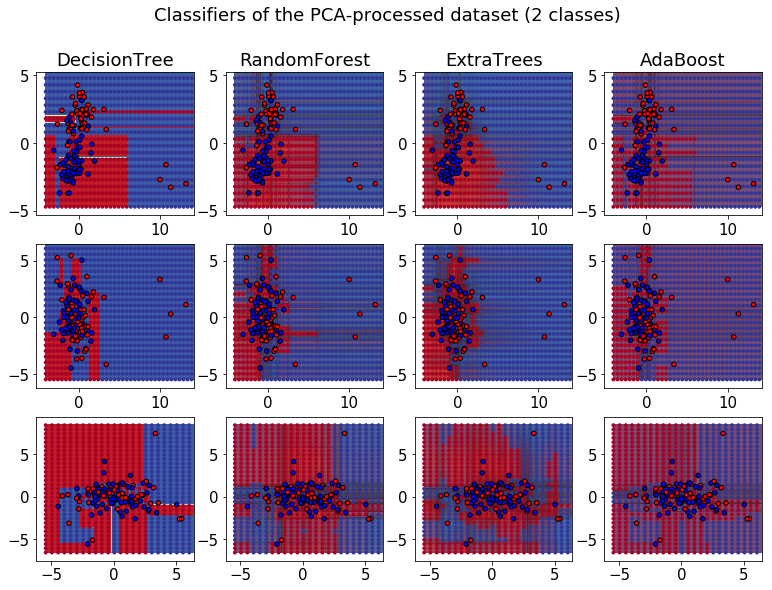

In [115]:

# Parameters
n_classes = n_classes = len(np.unique(cell_type))
n_estimators = 200

cmap = plt.cm.RdYlBu
plot_step = 0.01  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 14  # fix the seed on each iteration


plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=n_estimators, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features

        X = X_r[:, pair]
        y = cell_type_14

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
#        mean = X.mean(axis=0)
#        std = X.std(axis=0)
#        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(
            ".")[-1][:-2][:-len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(
                len(model.estimators_))
        print(model_details + " with features", pair,
              "has a score of", scores)

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                         yy_coarser.ravel()]
                                         ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                                c=Z_points_coarser, cmap=cmap,
                                edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(X[:, 0], X[:, 1], c=y,
                    cmap=ListedColormap(['b','r']),
                    edgecolor='k', s=20)
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers of the PCA-processed dataset (2 classes)")
plt.axis("tight")

plt.show()

# Random forest after PCA: PC1 and PC2

Classifier performance, PC1 & PC2 features only: 0.767857142857
('RandomForest with 200 estimators with features', [0, 1], 'has a score of', 1.0)


Text(0,0.5,'Principal component 2')

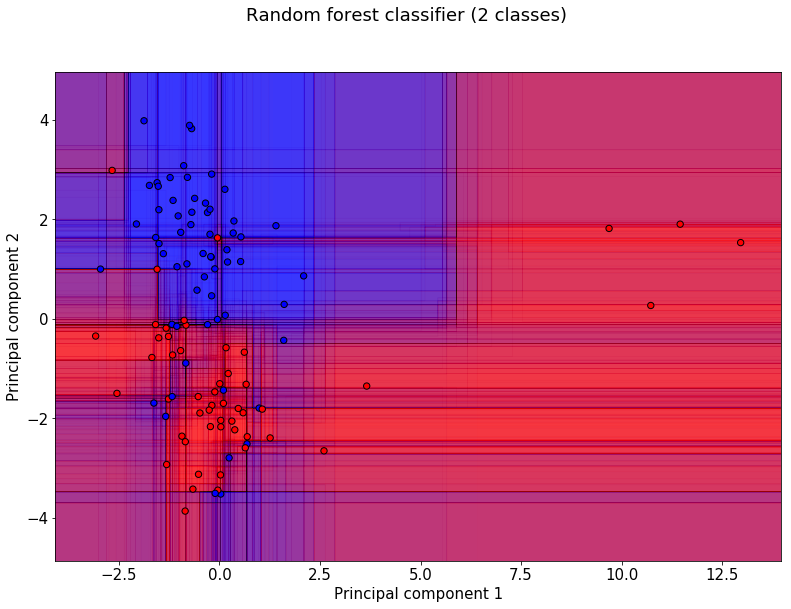

In [112]:
# Plot the decision boundary only for Random forest classifier


# Parameters
n_classes = 2
n_estimators = 200
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration


model=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=n_estimators, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)                    


pair=[0,1]

X = X_r[:, pair]
y = cell_type_14



# Shuffle
idx = np.arange(X.shape[0])
np.random.seed(RANDOM_SEED)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

# Train
clf = clone(model)
clf = model.fit(X, y)

# get the scores of the trees
scores = clf.score(X, y)

# print the model score
print 'Classifier performance, PC1 & PC2 features only: ' + str(clf.oob_score_)

# Create a title for each column and the console by using str() and
# slicing away useless parts of the string
model_title = str(type(model)).split(
    ".")[-1][:-2][:-len("Classifier")]

model_details = model_title
if hasattr(model, "estimators_"):
    model_details += " with {} estimators".format(
        len(model.estimators_))
print(model_details + " with features", pair,
      "has a score of", scores)


# Now plot the decision boundary using a fine mesh as input to a
# filled contour plot
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# Plot either a single DecisionTreeClassifier or alpha blend the
# decision surfaces of the ensemble of classifiers
if isinstance(model, DecisionTreeClassifier):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
else:
    # Choose alpha blend level with respect to the number
    # of estimators
    # that are in use (noting that AdaBoost can use fewer estimators
    # than its maximum if it achieves a good enough fit early on)
    estimator_alpha = 1.0 / len(model.estimators_)
    for tree in model.estimators_:
        Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=ListedColormap(['b','r']))

# Build a coarser grid to plot a set of ensemble classifications
# to show how these are different to what we see in the decision
# surfaces. These points are regularly space and do not have a
# black outline
xx_coarser, yy_coarser = np.meshgrid(
    np.arange(x_min, x_max, plot_step_coarser),
    np.arange(y_min, y_max, plot_step_coarser))
Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                 yy_coarser.ravel()]
                                 ).reshape(xx_coarser.shape)
#cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
#                        c=Z_points_coarser, cmap=cmap,
#                        edgecolors="none")

# Plot the training points, these are clustered together and have a blue-red outline


plt.scatter(X[:, 0], X[:, 1], c=y,
            cmap=ListedColormap(['b','r']),
            edgecolor='k', s=40)

plt.suptitle("Random forest classifier (2 classes)")
plt.axis("tight")
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
#plt.xlim((-1.5, 1.5))

#plt.savefig('Random_forest_visualisation_cortex.svg', format='svg', dpi=300)

# Running tSNE on post-PCA ephys feature set

Ephys dataset, perplexity=30 in 1.6 sec


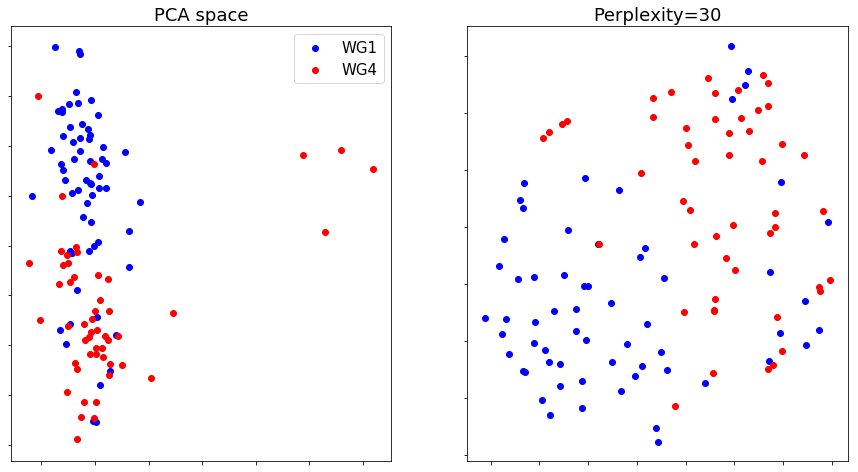

In [153]:


# Dataset description
#n_samples = 119

# Aiming to project to 2 componenets
n_components = 2

(fig, subplots) = plt.subplots(1, 2, figsize=(15, 8))
perplexities = [30]

pca = PCA(n_components=30)
# get the cell positions in the new coordinates
X_r = pca.fit(all_features_new_scaled).transform(all_features_new_scaled)


X = X_r[:,:]
y = cell_type_14

idx_1=np.where(cell_type==1)
idx_2=np.where(cell_type==4)


ax = subplots[0]

ax.scatter(X_r[idx_1, 0],X_r[idx_1, 1],c='blue')
ax.scatter(X_r[idx_2, 0],X_r[idx_2, 1],c='red')

ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
ax.set_title('PCA space')

# split by case type
ax.legend(['WG1','WG4'])


for i, perplexity in enumerate(perplexities):
    ax = subplots[i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity, metric='cosine',n_iter=20000)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("Ephys dataset, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)

    # plot different cells with different labels
    
    ax.scatter(Y[idx_1, 0],Y[idx_1, 1],c='blue')
    ax.scatter(Y[idx_2, 0],Y[idx_2, 1],c='red')
    
    
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

    
#plt.savefig('tSNE_perplexity_20_CASE.eps', format='eps', dpi=300)

#plt.show()

# k-means clustering on PCA features: 2 clusters

n_clusters: 2, 	 n_samples 112, 	 n_features 30
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.02s	2812	0.042	0.187	0.069	0.018	0.034	0.540
random   	0.01s	2812	0.042	0.187	0.069	0.018	0.034	0.540
PCA-based	0.00s	2992	0.200	0.200	0.200	0.262	0.194	0.128
__________________________________________________________________________________


([], <a list of 0 Text yticklabel objects>)

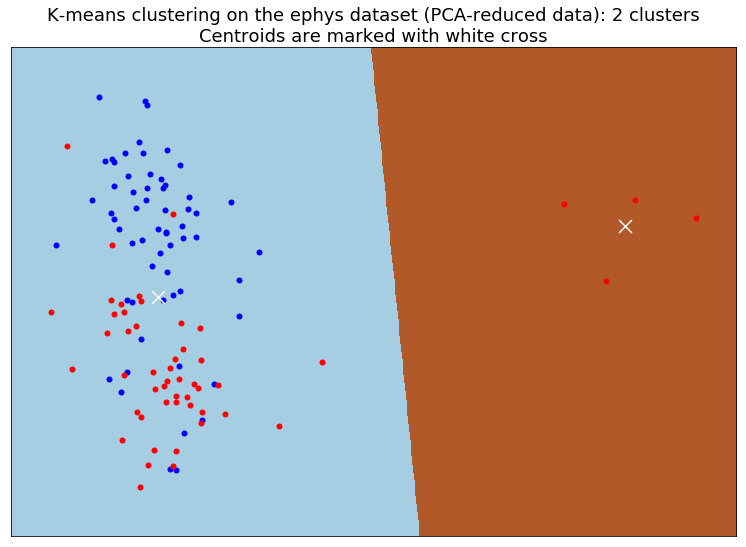

In [118]:
# run k-means on the code: 2 clusters

# set up a random seed
np.random.seed(0)

data = all_features_new_scaled

n_samples, n_features = data.shape
n_clusters = 2
labels = cell_type_14
#labels = digits.target

sample_size = len(cell_names)

print("n_clusters: %d, \t n_samples %d, \t n_features %d"
      % (n_clusters, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_clusters, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_clusters, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_clusters).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_clusters, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# plot all WG1 
plt.plot(reduced_data[np.where(cell_type_14==1), 0], reduced_data[np.where(cell_type_14==1), 1], 'k.', markersize=10,color='blue')
plt.plot(reduced_data[np.where(cell_type_14==4), 0], reduced_data[np.where(cell_type_14==4), 1], 'k.', markersize=10,color='red')

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the ephys dataset (PCA-reduced data): 2 clusters\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

#plt.savefig('k_means_PCA.eps', format='eps', dpi=300)

In [122]:
# k-means clustering on post tSNE features: 2 clusters

n_clusters: 2, 	 n_samples 112, 	 n_features 2
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.02s	1566	0.327	0.325	0.326	0.408	0.320	0.450
random   	0.01s	1566	0.327	0.325	0.326	0.408	0.320	0.450
PCA-based	0.00s	1566	0.327	0.325	0.326	0.408	0.320	0.450
__________________________________________________________________________________


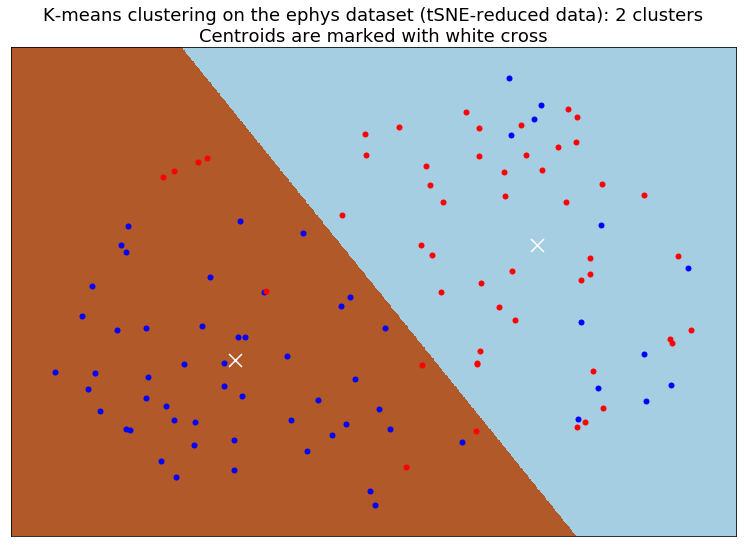

In [117]:
# run k-means on the code: 2 clusters

# set up a random seed
np.random.seed(43)

data = Y

n_samples, n_features = data.shape
n_clusters = 2
labels = cell_type_14
#labels = digits.target

sample_size = 119

print("n_clusters: %d, \t n_samples %d, \t n_features %d"
      % (n_clusters, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_clusters, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_clusters, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_clusters).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_clusters, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

# no PCA post-processing
#reduced_data = PCA(n_components=2).fit_transform(data)
reduced_data=data

kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# plot all WG1 
plt.plot(reduced_data[np.where(cell_type_14==1), 0], reduced_data[np.where(cell_type_14==1), 1], 'k.', markersize=10,color='blue')
plt.plot(reduced_data[np.where(cell_type_14==4), 0], reduced_data[np.where(cell_type_14==4), 1], 'k.', markersize=10,color='red')

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the ephys dataset (tSNE-reduced data): 2 clusters\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.savefig('k_means_tSNE.eps', format='eps', dpi=300)